In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

pd.set_option("max_columns", 999)
pd.set_option("max_rows", 999)

In [308]:
Player_information = pd.read_csv('Player_info_added_perday.csv', engine='python')
Player_action = pd.read_csv('Player_action_added_perday.csv', engine='python')
Group_activity = pd.read_csv('Group_activity.csv', engine='python')
labeled_accounts = pd.read_csv('labeled_accounts.csv', engine='python')

# merge // get train and validation sets (get only the accounts labeled)

In [309]:
final = pd.merge(Player_information, Player_action, how='outer', on = "actor_account")
final = pd.merge(final, Group_activity, how='outer',  on = "actor_account")

In [310]:
final = pd.merge(final, labeled_accounts, how='inner', on = 'actor_account')
final.fillna(0, inplace=True)
print(final.shape)
final.head()

(8100, 33)


,actor_account,login_count,logout_count,login_day_count,play_time,avg_money,ip_count,max_level,login_total_day_x,playtime_per_day,sit_count,exp_get_amout,item_get_count,exp_repair_count,money_get_count,abyss,use_portal_count,killed_by_pc,killed_by_npc,teleport_count,reborn_count,question_count,login_total_day_y,sit_count_perday,item_get_count_perday,exp_repair_count_perday,money_get_count_perday,use_portal_count_perday,teleport_count_perday,total_party_time,guild_join_count,average_party_time,class
0,20000005,259,259,1,637926,124.849465,259,0,15,42528.40000,270,389149580,31149,0,4686,0,0,47,30,376,51,62,15,18.000000,2076.600000,0.0,312.400000,0.000000,25.066667,8862.0,0.0,1477.000000,0
1,20000016,38,37,1,401885,43.509962,38,42,14,28706.07143,153,80119427,61579,0,1596,0,0,32,75,343,75,5893,14,10.928571,4398.500000,0.0,114.000000,0.000000,24.500000,69458.0,0.0,3655.684211,0
2,20000033,43,42,1,240334,-6.613812,43,38,14,17166.71429,378,142485377,24686,0,1318,0,0,35,53,337,69,97,14,27.000000,1763.285714,0.0,94.142857,0.000000,24.071429,43619.0,0.0,2295.736842,0
3,20000035,25,24,1,1205493,0.088531,25,0,15,80366.20000,207,1377552887,109795,0,7979,0,0,0,12,44,10,0,15,13.800000,7319.666667,0.0,531.933333,0.000000,2.933333,0.0,0.0,0.000000,0
4,20000051,110,109,1,457433,-32.874878,110,0,15,30495.53333,320,395099069,98368,0,3551,0,1,311,109,568,261,80,15,21.333333,6557.866667,0.0,236.733333,0.066667,37.866667,40934.0,0.0,2558.375000,0


## Simple EDA

In [311]:
model_data = final.copy()

# Login_count and Logout_count is virtually the same. Remove Logout_count
del model_data['logout_count']

# check if there is any nan values
for i in model_data.columns:
    model_data[model_data[i] == np.nan]

# There are inf values. Change it to max value in the column
for i in model_data.columns:
    model_data.loc[model_data[i] == np.inf, i] = np.nan
    model_data.loc[np.isnan(model_data[i]), i] = max(model_data[i])

## Correlation Cofficient 
    1. Actor_account is a dummy variable. Any variable that has a lower contribution than actor_account should be deleted
    2. Exp_repair_count a single value of 1. This should be deleted

In [312]:
x = model_data.iloc[:, :-1]
y = model_data.iloc[:, -1]

In [315]:
for i in range(0, len(x.columns)):
    if abs(np.corrcoef(x.iloc[:,i], y)[0,1]) > abs(np.corrcoef(x['actor_account'], y)[0,1]):
        print(x.columns[i], np.corrcoef(x.iloc[:,i], y)[0,1])

login_count -0.05176935312645625
play_time 0.14294229185493634
ip_count -0.05176935312645625
max_level 0.09093472319491953
login_total_day_x -0.14704220318195943
playtime_per_day 0.3749819266878865
sit_count 0.1238850846423584
exp_get_amout -0.11734438439216478
money_get_count 0.18601811721751838
abyss -0.052654698021253214
use_portal_count -0.08389118248457643
killed_by_pc -0.03356950907126214
teleport_count -0.04554341869495468
reborn_count 0.0846163330018644
login_total_day_y -0.14704220318195943
sit_count_perday 0.24494453878892125
item_get_count_perday 0.07589103723503555
money_get_count_perday 0.2465620112702065
use_portal_count_perday -0.08379207883530233
teleport_count_perday 0.04071646410226886
total_party_time -0.11445935957046192
guild_join_count -0.019502640900829173
average_party_time -0.04562800100341479


In [316]:
del model_data['exp_repair_count']

## Lasso (Model Based Feature Selection)

In [317]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)

lasso = Lasso().fit(x_train, y_train)

print('{:.3f}'.format(lasso.score(x_train, y_train)))
print('{:.3f}'.format(lasso.score(x_test, y_test)))

0.372
0.376


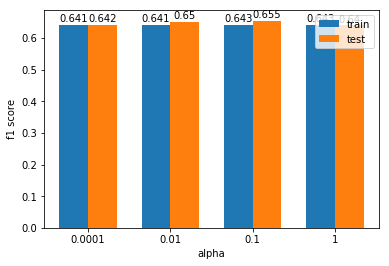

In [322]:
import matplotlib.pyplot as plt

alpha_set = [0.0001, 0.01, 0.1, 1]
max_inter_set = [10000000, 100000, 10000, 1000]

train_score = []
test_score = []
used_feature = []

for a, m in zip(alpha_set, max_inter_set):
    lasso_tr_y = lasso.predict(x_train)
    lasso_t_y = lasso.predict(x_test)
    lasso = Lasso(alpha=a, max_iter=m).fit(x_train, y_train)
    la_tr_score = np.round(f1_score((lasso.predict(x_train) > np.percentile(lasso_tr_y, 93)).astype(int), y_train), 3)
    la_te_score = np.round(f1_score((lasso.predict(x_test) > np.percentile(lasso_t_y, 93)).astype(int), y_test), 3)
    number_used = np.sum(lasso.coef_ != 0)

    train_score.append(la_tr_score)
    test_score.append(la_te_score)
    used_feature.append(number_used)

index = np.arange(len(alpha_set))
bar_width = 0.35
plt.bar(index, train_score, width=bar_width, label='train')
plt.bar(index+bar_width, test_score, width=bar_width, label='test')
plt.xticks(index+bar_width/2, alpha_set) # bar그래프 dodge를 하기 위해 기준값에 보정치를 더해줍니다.


for i, (ts, te) in enumerate(zip(train_score, test_score)):
    plt.text(i, ts+0.01, str(ts), horizontalalignment='center')
    plt.text(i+bar_width, te+0.01, str(te), horizontalalignment='center')

plt.legend(loc=1, )
plt.xlabel('alpha')
plt.ylabel('f1 score')
plt.show()

## Results of Feature Selection by Lasso

In [319]:
# when alpha is 1

lasso = Lasso(alpha=1, max_iter=1000).fit(x_train, y_train)

lasso_tr_y = lasso.predict(x_train)
lasso_t_y = lasso.predict(x_test)

for i in range(0, len(x.columns)):
    if abs(lasso.coef_[i]) > abs(lasso.coef_[0]):
        print(x.columns[i], lasso.coef_[i])

play_time -4.7210972077224566e-07
avg_money 4.852877849955507e-07
playtime_per_day 1.1741909586128984e-05
sit_count 6.530917559583621e-06
item_get_count 4.690873766250921e-07
money_get_count 4.852159413918258e-06
question_count -2.639537608669428e-06
item_get_count_perday -5.0572499439930335e-06
money_get_count_perday 1.0989835894298573e-05
total_party_time -3.9082765533339156e-07
average_party_time 5.71660790099008e-07


In [320]:
# when alpha is 0.1

lasso = Lasso(alpha=0.1, max_iter=10000).fit(x_train, y_train)

lasso_tr_y = lasso.predict(x_train)
lasso_t_y = lasso.predict(x_test)

for i in range(0, len(x.columns)):
    if abs(lasso.coef_[i]) > abs(lasso.coef_[0]):
        print(x.columns[i], lasso.coef_[i])

login_count -1.63625415258408e-05
play_time -3.797371592711145e-07
avg_money 5.492232001803665e-07
playtime_per_day 1.0355074112174055e-05
sit_count -2.4615444169718628e-05
item_get_count 4.5781862438399883e-07
money_get_count 2.7101058156836654e-06
killed_by_pc -0.0001128304468100176
killed_by_npc -1.0977442259426142e-05
teleport_count -1.077587937813556e-06
reborn_count 0.00010291918353424822
question_count -5.919730676346058e-06
sit_count_perday 0.00039538847186311135
item_get_count_perday -4.735979603462684e-06
money_get_count_perday 3.5603177502757695e-05
total_party_time -3.933332068488866e-07
average_party_time 6.379935098902576e-07


In [321]:
# when alpha is 0.01

lasso = Lasso(alpha=0.01, max_iter=100000).fit(x_train, y_train)

lasso_tr_y = lasso.predict(x_train)
lasso_t_y = lasso.predict(x_test)

for i in range(0, len(x.columns)):
    if abs(lasso.coef_[i]) > abs(lasso.coef_[0]):
        print(x.columns[i], lasso.coef_[i])

login_count -2.5858717744499037e-05
play_time -4.809503691661419e-07
avg_money 5.020730348871418e-07
ip_count -5.350378034055097e-07
max_level 0.00023450999599520413
login_total_day_x 0.00045036194462897967
playtime_per_day 1.1438524360492797e-05
sit_count -2.924157774634127e-05
item_get_count 4.1694857435460473e-07
money_get_count 2.746069336411666e-06
abyss 1.436909822091598e-05
killed_by_pc -0.0001552000831736176
killed_by_npc -7.971814423729104e-05
teleport_count 0.0002103414478006949
reborn_count 0.00019731223644957392
question_count -6.9768000819355534e-06
login_total_day_y 5.2881727119497375e-05
sit_count_perday 0.0004468064642282371
item_get_count_perday -4.291143302951836e-06
money_get_count_perday 3.4627200381249224e-05
teleport_count_perday -0.0033539918478458575
total_party_time -3.9127012937597016e-07
average_party_time 6.770997514359674e-07
